In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

#check all the files in the input dataset
#print(os.listdir("../input/"))

In [ ]:
#choosing DOM_hourly.csv data for analysis
fpath='/content/DOM_hourly - DOM_hourly.csv'

df=pd.read_csv(fpath)
df.head()

,Datetime,DOM_MW
0,2005-12-31 1:00:00,9389
1,2005-12-31 2:00:00,9070
2,2005-12-31 3:00:00,9001
3,2005-12-31 4:00:00,9042
4,2005-12-31 5:00:00,9132


In [ ]:
df = pd.read_csv(fpath, index_col='Datetime', parse_dates=['Datetime'])
df.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389
2005-12-31 02:00:00,9070
2005-12-31 03:00:00,9001
2005-12-31 04:00:00,9042
2005-12-31 05:00:00,9132


In [ ]:
#checking missing data
df.isna().sum()

,0
DOM_MW,0


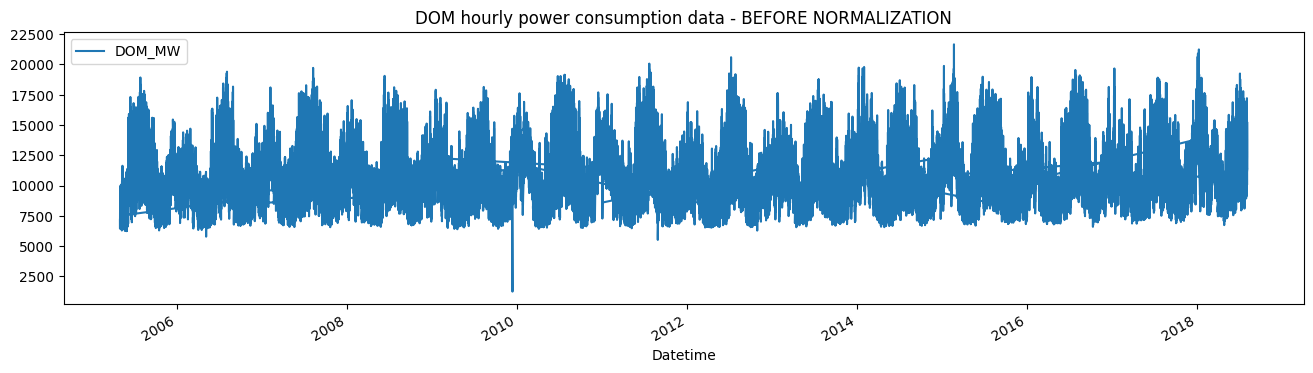

In [ ]:
df.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - BEFORE NORMALIZATION')

plt.show()

In [ ]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['DOM_MW']=scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

(116189, 1)

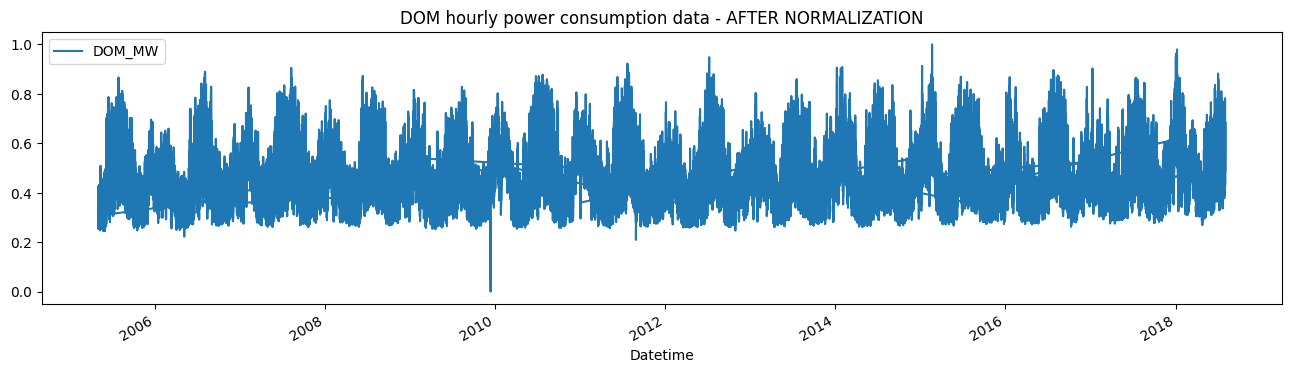

In [ ]:
df_norm.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - AFTER NORMALIZATION')

plt.show()

In [ ]:
df_norm.shape

(116189, 1)

In [ ]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])

    #1 last 6189 days are going to be used in test
    X_test = X_train[110000:]
    y_test = y_train[110000:]

    #2 first 110000 days are going to be used in training
    X_train = X_train[:110000]
    y_train = y_train[:110000]


    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    print(X_train.shape)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (110000, seq_len, 1))
    print(X_train.shape)

    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))

    return [X_train, y_train, X_test, y_test]

In [ ]:
#create train, test data
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

(110000, 20)
(110000, 20, 1)
X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (6169, 20, 1)
y_test.shape =  (6169,)


In [ ]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 20, 40)         │         1,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 20, 40)         │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,201 (32.04 KB)

 Trainable params: 8,201 (32.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000, validation_data=(X_test, y_test))

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0050 - val_loss: 6.8085e-04
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022 - val_loss: 6.2923e-04
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0019 - val_loss: 5.9640e-04
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017 - val_loss: 6.0513e-04
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015 - val_loss: 5.6113e-04
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0014 - val_loss: 5.4614e-04
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013 - val_loss: 5.4677e-04
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012 - val_loss: 6.7328e-04
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - val_loss: 6.2205e-04
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010 - val_loss: 5.5693e-04


In [ ]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
R2 Score of RNN model =  0.9501483784444876


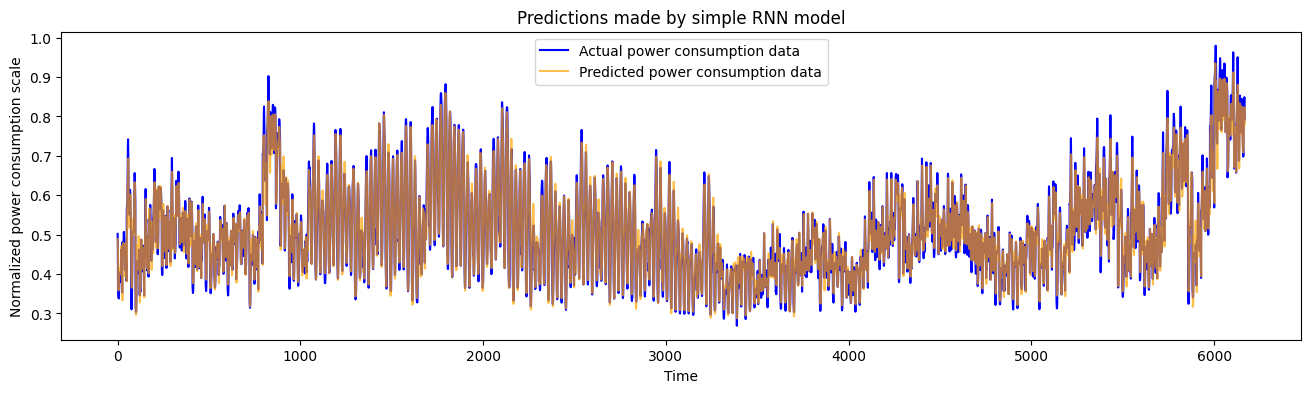

In [ ]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()

plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

In [ ]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 40)         │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 40)         │        12,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 40)             │        12,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,681 (127.66 KB)

 Trainable params: 32,681 (127.66 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000, validation_data=(X_test, y_test))

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0036 - val_loss: 6.7378e-04
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0016 - val_loss: 6.9545e-04
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0015 - val_loss: 6.2452e-04
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - val_loss: 6.5751e-04
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013 - val_loss: 6.0153e-04
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0012 - val_loss: 5.9938e-04
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0012 - val_loss: 5.7205e-04
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0011 - val_loss: 6.4082e-04
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0010 - val_loss: 5.5561e-04
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.6180e-04 - val_loss: 5.7597e-04


In [ ]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
R^2 Score of LSTM model =  0.9543474129340365


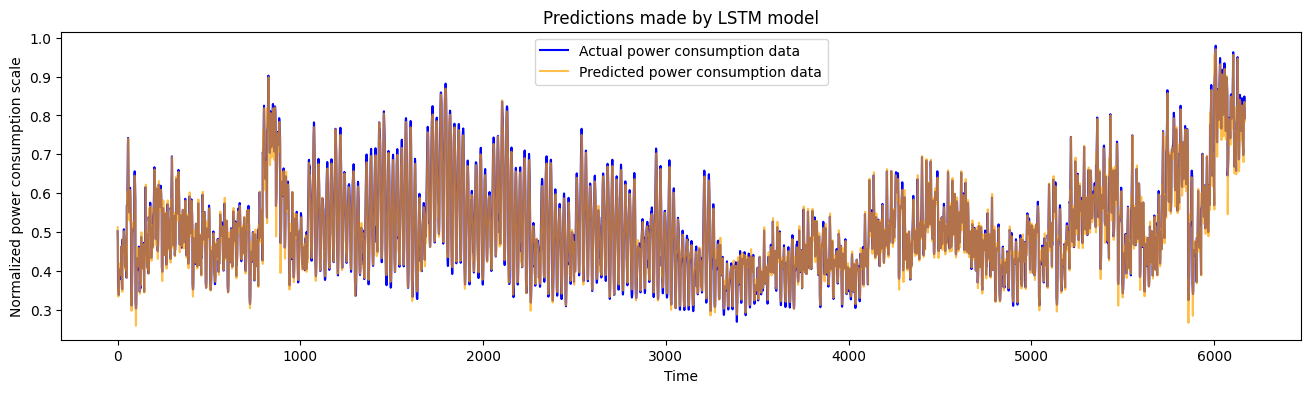

In [ ]:
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

In [ ]:
from keras.layers import GRU

gru_model = Sequential()

gru_model.add(GRU(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
gru_model.add(Dropout(0.15))

gru_model.add(GRU(40,activation="tanh",return_sequences=True))
gru_model.add(Dropout(0.15))

gru_model.add(GRU(40,activation="tanh",return_sequences=False))
gru_model.add(Dropout(0.15))

gru_model.add(Dense(1))

gru_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 20, 40)         │         5,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 20, 40)         │         9,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 20, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 40)             │         9,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,881 (97.19 KB)

 Trainable params: 24,881 (97.19 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
gru_model.compile(optimizer="adam",loss="MSE")
gru_model.fit(X_train, y_train, epochs=10, batch_size=1000, validation_data=(X_test, y_test))

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0019 - val_loss: 6.3601e-04
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013 - val_loss: 6.3728e-04
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0012 - val_loss: 6.2540e-04
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0011 - val_loss: 6.1721e-04
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0010 - val_loss: 6.5047e-04
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.4825e-04 - val_loss: 6.0483e-04
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.7797e-04 - val_loss: 7.4218e-04
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.4253e-04 - val_loss: 5.8627e-04
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.7059e-04 - val_loss: 5.8877e-04
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.1766e-04 - val_loss: 6.1899e-04


- **Let's check r2 score for the values predicted by the above trained GRU model**

In [ ]:
gru_predictions = gru_model.predict(X_test)

gru_score = r2_score(y_test, gru_predictions)
print("R2 Score of GRU model = ",gru_score)

193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
R2 Score of GRU model =  0.9571982032064756


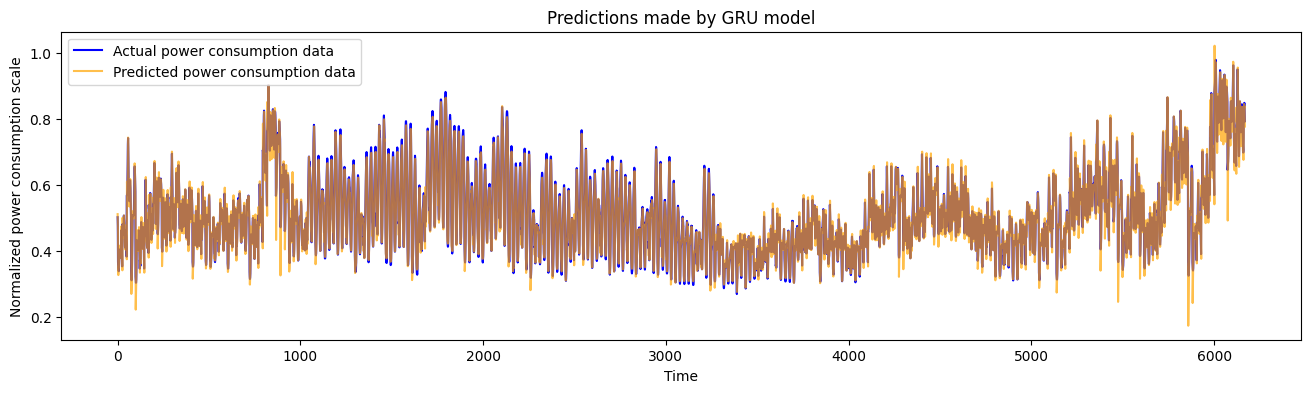

In [ ]:
plot_predictions(y_test, gru_predictions, "Predictions made by GRU model")

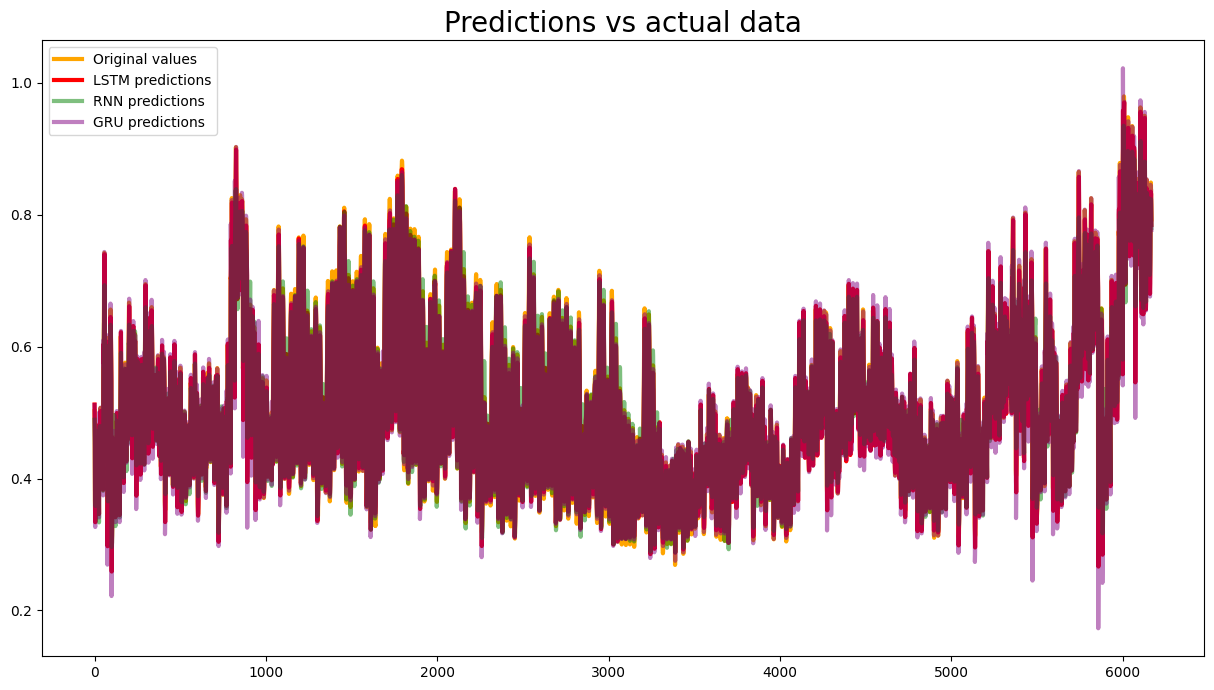

In [ ]:
plt.figure(figsize=(15,8))

plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="green", linewidth=3, label="RNN predictions")
plt.plot(gru_predictions, alpha=0.5, c="purple", linewidth=3, label="GRU predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()

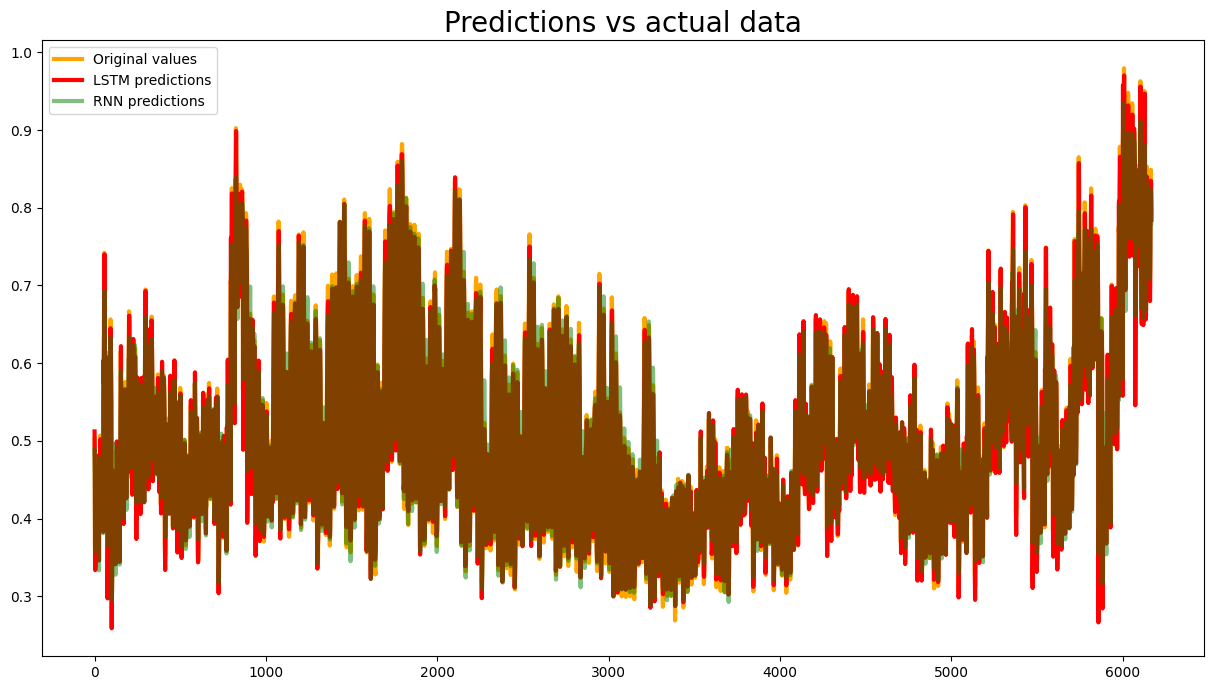

In [ ]:
plt.figure(figsize=(15,8))

plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="green", linewidth=3, label="RNN predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()

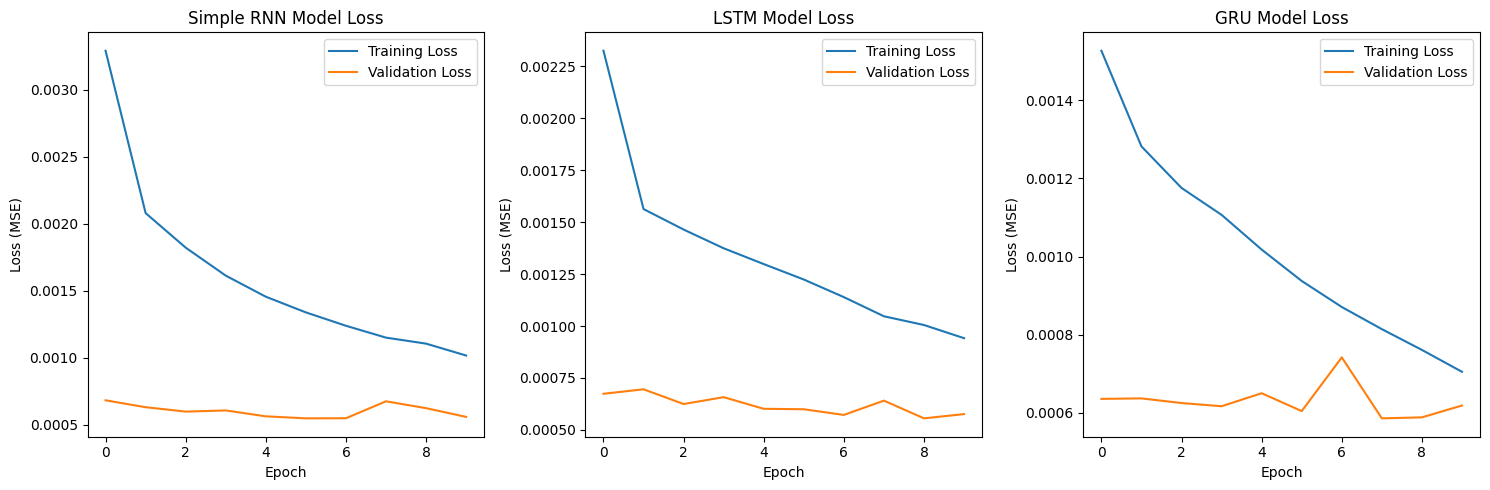

In [ ]:
plt.figure(figsize=(15, 5))

# Plot RNN loss
plt.subplot(1, 3, 1)
plt.plot(rnn_model.history.history['loss'], label='Training Loss')
plt.plot(rnn_model.history.history['val_loss'] if 'val_loss' in rnn_model.history.history else [], label='Validation Loss') # Check if validation loss exists
plt.title('Simple RNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

# Plot LSTM loss
plt.subplot(1, 3, 2)
plt.plot(lstm_model.history.history['loss'], label='Training Loss')
plt.plot(lstm_model.history.history['val_loss'] if 'val_loss' in lstm_model.history.history else [], label='Validation Loss') # Check if validation loss exists
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

# Plot GRU loss
plt.subplot(1, 3, 3)
plt.plot(gru_model.history.history['loss'], label='Training Loss')
plt.plot(gru_model.history.history['val_loss'] if 'val_loss' in gru_model.history.history else [], label='Validation Loss') # Check if validation loss exists
plt.title('GRU Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.tight_layout()
plt.show()